In [62]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import urllib.request
import pandas as pd
import urllib
import tarfile
import os
import numpy as np
np.random.seed(42)
import sklearn
import seaborn as sns # importing seaborn for the heatmap
import sys
assert sys.version_info >= (3, 5)
from sklearn.preprocessing import OrdinalEncoder
# Python ≥3.5 is required

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# add from here --------------------------------------------------------------------------------------------
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
from glob import glob 
import matplotlib.image as mpimg
from skimage.io import imread 
import tensorflow as tf
assert tf.__version__ >= "2.0"
from skimage import io
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, average_precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from tensorflow.keras.layers import (BatchNormalization, SeparableConv2D, Activation)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils


In [63]:
# NECESSARY IN KAGGLE NOTEBOOK ONLY
#get files
# test_path = '../input/histopathologic-cancer-detection/test/'
# train_path = '../input/histopathologic-cancer-detection/train/'
# sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
# train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

df = pd.read_csv('train_labels.csv')
print("dimensions:",df.shape)  # to understand the dimensions of the dataset
# to display the number of rows/instances
print("rows = {}".format(df.shape[0]))
# to display the number of columns/attributes
print("columns = {}".format(df.shape[1]))

dimensions: (220025, 2)
rows = 220025
columns = 2


In [3]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [57]:
base_tile_dir = 'train'
data = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))}) # to add lines with.tif to the paths of the images
# print(data.head())
data['id'] = data.path.map(lambda x: os.path.basename(x).split('.')[0]) # to get the image id from the image's name when split by the / in the path
data = data.merge(df, on = "id")

In [5]:
data.head

<bound method NDFrame.head of                                                    path  \
0     train\0000d563d5cfafc4e68acb7c9829258a298d9b6a...   
1     train\0000da768d06b879e5754c43e2298ce48726f722...   
2     train\0000f8a4da4c286eee5cf1b0d2ab82f979989f7b...   
3     train\000a2a35668f04edebc0b06d5d133ad90c93a044...   
4     train\000aa5d8f68dc1f45ebba53b8f159aae80e06072...   
...                                                 ...   
4995  train\0f9efcb43cf988f7b3353e0da9469362d18f0201...   
4996  train\0f9f21b84999b2c4573b253b1b45449facb79d0e...   
4997  train\0f9f36b2a572c224258af7655db9d513d7519bf4...   
4998  train\0f9fb92dcadd853d2e56be05ffa2861ab3a86f7e...   
4999  train\0f9fc09886f93460dace9104bf948248173af5ec...   

                                            id  label  
0     0000d563d5cfafc4e68acb7c9829258a298d9b6a      0  
1     0000da768d06b879e5754c43e2298ce48726f722      1  
2     0000f8a4da4c286eee5cf1b0d2ab82f979989f7b      0  
3     000a2a35668f04edebc0b06d5d133ad

In [6]:
data.shape

(5000, 3)

In [7]:
data.info() # to understand the columns and their types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    5000 non-null   object
 1   id      5000 non-null   object
 2   label   5000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 156.2+ KB


In [8]:
data.isnull().sum().sum()  # to check for any null values in the dataset

0

In [9]:
data.duplicated().describe() # one unique value of false means no duplicate value

count      5000
unique        1
top       False
freq       5000
dtype: object

In [10]:
# non-malignant cases- 0
# malignant cases- 1
vc = data['label'].value_counts()
vc

0    2985
1    2015
Name: label, dtype: int64

<AxesSubplot:ylabel='label'>

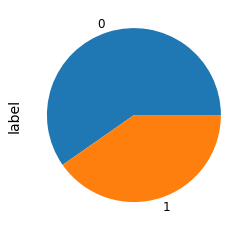

In [11]:
data['label'].value_counts().plot(kind="pie")

In [12]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [64]:
m = data.loc[data['label']==1] # malignant
nm = data.loc[data['label']==0] # non-malignant #['id'].values

In [65]:
# to sample as many random images as possible (so 89117 is the least of the two values) and ensure the tranining set has equal number of of 0 and 1 cases
custom_image_data = pd.concat([m.sample(vc[1],random_state=42), nm.sample(vc[1],random_state=42)], axis=0, ignore_index=True).reset_index()
custom_image_data['label'].value_counts() # to verify the process 

1    2015
0    2015
Name: label, dtype: int64

In [66]:
custom_image_data.columns

Index(['index', 'path', 'id', 'label'], dtype='object')

 #### 0 - No cancer cells, 1 - Cancer cells

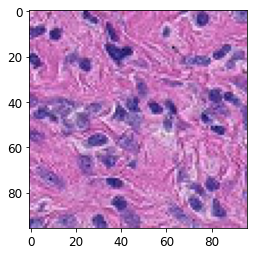

In [67]:
img = mpimg.imread(f'train/{custom_image_data.iloc[0][2]}.tif')
imgplot = plt.imshow(img)

In [68]:
# read images from files
custom_image_data['image'] = custom_image_data['path'].map(imread)
custom_image_data.head()

,index,path,id,label,image
0,0,train\0d0d806f2899e4be15eca3a0b4459534887a0252...,0d0d806f2899e4be15eca3a0b4459534887a0252,1,"[[[236, 182, 205], [255, 200, 231], [208, 139,..."
1,1,train\0b266b0794520b9cc0a4895c36ac88994e649168...,0b266b0794520b9cc0a4895c36ac88994e649168,1,"[[[124, 80, 141], [131, 87, 146], [143, 100, 1..."
2,2,train\0ac16cbe61771f5092293467c9755d30d5696e59...,0ac16cbe61771f5092293467c9755d30d5696e59,1,"[[[109, 60, 89], [229, 178, 211], [255, 212, 2..."
3,3,train\0dae394163423c95d14b00874634ccd9459130b7...,0dae394163423c95d14b00874634ccd9459130b7,1,"[[[110, 45, 137], [133, 76, 153], [224, 184, 2..."
4,4,train\0ad66f607ce3d3a186fea3d1ca420730b3afe542...,0ad66f607ce3d3a186fea3d1ca420730b3afe542,1,"[[[212, 129, 207], [204, 125, 206], [176, 103,..."


In [69]:
input_images = np.stack(list(custom_image_data.image), axis = 0)
input_images.shape

(4030, 96, 96, 3)

In [20]:
train_fraction = 0.8

encoder = LabelBinarizer()
y = encoder.fit_transform(custom_image_data.label)
x = input_images

train_tensors, test_tensors, train_targets, test_targets =\
    train_test_split(x, y, train_size = train_fraction, random_state = 42)

val_size = int(0.5*len(test_tensors))


val_tensors = test_tensors[:val_size]
val_targets = test_targets[:val_size]
test_tensors = test_tensors[val_size:]
test_targets = test_targets[val_size:]

In [26]:
num_folds = 10

# Merge inputs and targets
inputs = np.concatenate((train_tensors, test_tensors), axis=0)
targets = np.concatenate((train_targets, test_targets), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
for train, test in kfold.split(inputs, targets):    

    model = Sequential()
    model.add(Dense(30, activation='relu', input_shape=(96, 96, 3)))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='sigmoid'))
    model.add(layers.Dropout(0.5))


    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))

In [27]:
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 10
model.fit(inputs[train], targets[train],
          epochs=epochs, batch_size=80, verbose=1)

Epoch 1/10
41/41 [==============================] - 45s 853ms/step - loss: 13.7953 - accuracy: 0.5054
Epoch 2/10
41/41 [==============================] - 35s 858ms/step - loss: 1.1876 - accuracy: 0.6450
Epoch 3/10
41/41 [==============================] - 32s 783ms/step - loss: 0.5595 - accuracy: 0.7476
Epoch 4/10
41/41 [==============================] - 31s 750ms/step - loss: 0.4476 - accuracy: 0.7926
Epoch 5/10
41/41 [==============================] - 30s 744ms/step - loss: 0.4099 - accuracy: 0.8242
Epoch 6/10
41/41 [==============================] - 30s 743ms/step - loss: 0.3299 - accuracy: 0.8711
Epoch 7/10
41/41 [==============================] - 30s 738ms/step - loss: 0.2850 - accuracy: 0.8894
Epoch 8/10
41/41 [==============================] - 30s 733ms/step - loss: 0.2563 - accuracy: 0.9103
Epoch 9/10
41/41 [==============================] - 30s 731ms/step - loss: 0.2230 - accuracy: 0.9204
Epoch 10/10
41/41 [==============================] - 30s 731ms/step - loss: 0.1785 - accur

In [28]:
cancer_predictions =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]

def evaluate(cancer_predictions):

    test_accuracy = 100*np.sum(np.round(cancer_predictions).astype('int32')==test_targets.flatten())/len(cancer_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)


#     score = roc_auc_score(np.round(cancer_predictions).astype('int32'), test_targets)
    score = roc_auc_score(test_targets, cancer_predictions)

    print('ROC AUC Score: %.4f%%' % score)

    precision = precision_score(np.round(cancer_predictions).astype('int32'), test_targets)
    print('Precision score: %.4f%%' % precision)

    recall = recall_score(np.round(cancer_predictions).astype('int32'), test_targets)
    print('Recall Score: %.4f%%' % recall)

    f1 = f1_score(np.round(cancer_predictions).astype('int32'), test_targets)
    print('F1 Score: %.4f%%' % f1)

    cm = confusion_matrix(np.round(cancer_predictions).astype('int32'), test_targets)
    print("Confusion Matrix: \n %s" % cm)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])

    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    print('Sensitivity Score of the classifier is: ', sensitivity)

    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    print('Specificity Score of the classifier is: ', specificity)

evaluate(cancer_predictions)
    

1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 41ms/step
Test accuracy: 92.8040%
ROC AUC Score: 0.9798%
Precision score: 0.9615%
Recall Score: 0.9050%
F1 Score: 0.9324%
Confusion Matrix: 
 [[174   8]
 [ 21 200]]
True positive =  174
False positive =  8
False negative =  21
True negative =  200
Sensitivity Score of the classifier is:  0.9560439560439561
Specificity Score of the classifier is:  0.9049773755656109


#### Experimentation with hyperparameters

In [29]:
model = Sequential()
model.add(Dense(30, activation='relu', input_shape=(96, 96, 3)))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.add(layers.Dropout(0.5))


model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer= keras.optimizers.SGD(learning_rate = 1e-2), loss='binary_crossentropy', metrics=['accuracy']) #0.01
epochs = 5
model.fit(train_tensors, train_targets, 
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=50, verbose=1)

Epoch 1/5
65/65 [==============================] - 24s 344ms/step - loss: 0.8502 - accuracy: 0.4975 - val_loss: 0.7423 - val_accuracy: 0.4615
Epoch 2/5
65/65 [==============================] - 21s 320ms/step - loss: 0.7151 - accuracy: 0.5211 - val_loss: 0.7034 - val_accuracy: 0.5385
Epoch 3/5
65/65 [==============================] - 21s 327ms/step - loss: 0.7144 - accuracy: 0.5109 - val_loss: 0.6962 - val_accuracy: 0.5385
Epoch 4/5
65/65 [==============================] - 22s 332ms/step - loss: 0.7117 - accuracy: 0.4969 - val_loss: 0.6975 - val_accuracy: 0.4615
Epoch 5/5
65/65 [==============================] - 21s 328ms/step - loss: 0.7116 - accuracy: 0.4994 - val_loss: 0.7108 - val_accuracy: 0.4615


In [30]:
cancer_predictions =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]

evaluate(cancer_predictions)

1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 53ms/step
Test accuracy: 48.3871%
ROC AUC Score: 0.4293%
Precision score: 0.0000%
Recall Score: 0.0000%
F1 Score: 0.0000%
Confusion Matrix: 
 [[195 208]
 [  0   0]]
True positive =  195
False positive =  208
False negative =  0
True negative =  0
Sensitivity Score of the classifier is:  0.4838709677419355
Specificity Score of the classifier is:  nan


D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\geeta\AppData\Local\Temp\ipykernel_15648\2872331923.py:37: RuntimeWarning: invalid value encountered in longlong_scalars
  specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])


In [31]:
model.compile(optimizer= keras.optimizers.SGD(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy']) 
epochs = 10
model.fit(train_tensors, train_targets, 
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=10, verbose=1)

Epoch 1/10
323/323 [==============================] - 30s 84ms/step - loss: 0.6989 - accuracy: 0.5031 - val_loss: 0.6956 - val_accuracy: 0.4615
Epoch 2/10
323/323 [==============================] - 25s 78ms/step - loss: 0.7001 - accuracy: 0.4997 - val_loss: 0.6946 - val_accuracy: 0.4591
Epoch 3/10
323/323 [==============================] - 24s 73ms/step - loss: 0.7012 - accuracy: 0.4845 - val_loss: 0.6963 - val_accuracy: 0.4615
Epoch 4/10
323/323 [==============================] - 24s 75ms/step - loss: 0.6994 - accuracy: 0.4953 - val_loss: 0.6932 - val_accuracy: 0.4640
Epoch 5/10
323/323 [==============================] - 23s 72ms/step - loss: 0.6948 - accuracy: 0.5189 - val_loss: 0.6946 - val_accuracy: 0.4591
Epoch 6/10
323/323 [==============================] - 25s 78ms/step - loss: 0.6996 - accuracy: 0.5012 - val_loss: 0.6939 - val_accuracy: 0.4566
Epoch 7/10
323/323 [==============================] - 26s 80ms/step - loss: 0.6993 - accuracy: 0.5074 - val_loss: 0.6927 - val_accuracy:

In [32]:
cancer_predictions =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]

evaluate(cancer_predictions)

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 42ms/step
Test accuracy: 46.6501%
ROC AUC Score: 0.4429%
Precision score: 0.1731%
Recall Score: 0.4557%
F1 Score: 0.2509%
Confusion Matrix: 
 [[152 172]
 [ 43  36]]
True positive =  152
False positive =  172
False negative =  43
True negative =  36
Sensitivity Score of the classifier is:  0.4691358024691358
Specificity Score of the classifier is:  0.45569620253164556


In [33]:
#reduced layers 
model = Sequential()
model.add(Dense(30, activation='relu', input_shape=(96, 96, 3)))
model.add(layers.Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 5
model.fit(train_tensors, train_targets, 
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=80, verbose=1)

Epoch 1/5
41/41 [==============================] - 23s 518ms/step - loss: 1213.3708 - accuracy: 0.5257 - val_loss: 198.6564 - val_accuracy: 0.6055
Epoch 2/5
41/41 [==============================] - 20s 476ms/step - loss: 149.3627 - accuracy: 0.5921 - val_loss: 273.8228 - val_accuracy: 0.4615
Epoch 3/5
41/41 [==============================] - 20s 478ms/step - loss: 182.8515 - accuracy: 0.5769 - val_loss: 160.6488 - val_accuracy: 0.6303
Epoch 4/5
41/41 [==============================] - 19s 473ms/step - loss: 131.5339 - accuracy: 0.6312 - val_loss: 142.2502 - val_accuracy: 0.6129
Epoch 5/5
41/41 [==============================] - 19s 474ms/step - loss: 77.5736 - accuracy: 0.6818 - val_loss: 71.8412 - val_accuracy: 0.6476


In [34]:
cancer_predictions =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]

evaluate(cancer_predictions)

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 37ms/step
Test accuracy: 64.7643%
ROC AUC Score: 0.7052%
Precision score: 0.3654%
Recall Score: 0.8837%
F1 Score: 0.5170%
Confusion Matrix: 
 [[185 132]
 [ 10  76]]
True positive =  185
False positive =  132
False negative =  10
True negative =  76
Sensitivity Score of the classifier is:  0.583596214511041
Specificity Score of the classifier is:  0.8837209302325582


### MultiLayer Perceptron - Train-Test Split


80-20 Split

In [35]:
# our best architecture: 
def bestarch():
    model = Sequential()
    model.add(Dense(30, activation='relu', input_shape=(96, 96, 3)))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(20, activation='sigmoid'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(2, activation='sigmoid'))
    model.add(layers.Dropout(0.5))


    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer= keras.optimizers.SGD(learning_rate = 1e-2), loss='binary_crossentropy', metrics=['accuracy']) #0.01

    return model


def getAcc(cancer_predictions, targets):
    accuracy = 100*np.sum(np.round(cancer_predictions).astype('int32')==targets.flatten())/len(cancer_predictions)
    return accuracy




In [37]:
# 80-20 split
train_fraction = 0.8

encoder = LabelBinarizer()
y = encoder.fit_transform(custom_image_data.label)
x = input_images

train_tensors, test_tensors, train_targets, test_targets =\
    train_test_split(x, y, train_size = train_fraction, random_state = 42)

epochs = 5
class1 =  bestarch()
class1.fit(train_tensors, train_targets, epochs=epochs, batch_size=50, verbose=1)


cancer_predictions =  [class1.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in train_tensors]

getAcc(cancer_predictions, train_targets)


cancer_predictions =  [class1.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]

getAcc(cancer_predictions, test_targets)

Epoch 1/5
65/65 [==============================] - 23s 314ms/step - loss: 2.8792 - accuracy: 0.4922
Epoch 2/5
65/65 [==============================] - 22s 332ms/step - loss: 0.7530 - accuracy: 0.4960
Epoch 3/5
65/65 [==============================] - 20s 304ms/step - loss: 0.7220 - accuracy: 0.5099
Epoch 4/5
65/65 [==============================] - 20s 307ms/step - loss: 0.7134 - accuracy: 0.5112
Epoch 5/5
1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 42ms/step


47.27047146401985

50 - 50 Train - Test Split

In [38]:
# 50-50 split
train_fraction = 0.5


train_tensors, test_tensors, train_targets, test_targets =\
    train_test_split(x, y, train_size = train_fraction, random_state = 42)

epochs = 5
class2 =  bestarch()
class2.fit(train_tensors, train_targets, epochs=epochs, batch_size=50, verbose=1)


cancer_predictions =  [class2.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in train_tensors]

getAcc(cancer_predictions, train_targets)


cancer_predictions =  [class2.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]

getAcc(cancer_predictions, test_targets)

Epoch 1/5
41/41 [==============================] - 16s 341ms/step - loss: 3.5468 - accuracy: 0.5017
Epoch 2/5
41/41 [==============================] - 14s 330ms/step - loss: 0.8581 - accuracy: 0.5127
Epoch 3/5
41/41 [==============================] - 13s 325ms/step - loss: 0.7684 - accuracy: 0.5042
Epoch 4/5
41/41 [==============================] - 13s 320ms/step - loss: 0.7380 - accuracy: 0.4933
Epoch 5/5
1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 57ms/step


49.18114143920595

20 - 80 Train- Test Split

In [40]:
# 20-80 split
train_fraction = 0.2

train_tensors, test_tensors, train_targets, test_targets =\
    train_test_split(x, y, train_size = train_fraction, random_state = 42)

epochs = 5
class3 =  bestarch()
class3.fit(train_tensors, train_targets, epochs=epochs, batch_size=50, verbose=1)


cancer_predictions =  [class3.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in train_tensors]

getAcc(cancer_predictions,train_targets)


cancer_predictions =  [class3.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]

getAcc(cancer_predictions, test_targets)

Epoch 1/5
17/17 [==============================] - 9s 347ms/step - loss: 3.5465 - accuracy: 0.5000
Epoch 2/5
17/17 [==============================] - 6s 337ms/step - loss: 1.7159 - accuracy: 0.4801
Epoch 3/5
17/17 [==============================] - 6s 336ms/step - loss: 0.8975 - accuracy: 0.5323
Epoch 4/5
17/17 [==============================] - 6s 334ms/step - loss: 0.8076 - accuracy: 0.4901
Epoch 5/5
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 31ms/step


49.50372208436725

In [41]:
np.random.seed(42)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                               verbose=1, save_best_only=True)

def backbone():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3)) 

    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3)) 

    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
    model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'elu'))

    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid')) 

    return model

model = backbone()

In [42]:
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 5
model.fit(train_tensors, train_targets, 
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=80, verbose=1)

Epoch 1/5
11/11 [==============================] - 57s 3s/step - loss: 3.0726 - accuracy: 0.4777 - val_loss: 0.8536 - val_accuracy: 0.4615
Epoch 2/5
11/11 [==============================] - 24s 2s/step - loss: 0.7603 - accuracy: 0.5223 - val_loss: 0.7097 - val_accuracy: 0.4615
Epoch 3/5
11/11 [==============================] - 25s 2s/step - loss: 0.7029 - accuracy: 0.5236 - val_loss: 0.6920 - val_accuracy: 0.6030
Epoch 4/5
11/11 [==============================] - 25s 2s/step - loss: 0.6881 - accuracy: 0.5658 - val_loss: 0.6849 - val_accuracy: 0.5682
Epoch 5/5
11/11 [==============================] - 26s 2s/step - loss: 0.7004 - accuracy: 0.5025 - val_loss: 0.6900 - val_accuracy: 0.5385


In [43]:
cancer_predictions =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]

evaluate(cancer_predictions)

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 64ms/step
Test accuracy: 50.4963%
ROC AUC Score: 0.6147%
Precision score: 1.0000%
Recall Score: 0.5050%
F1 Score: 0.6711%
Confusion Matrix: 
 [[   0    0]
 [1596 1628]]
True positive =  0
False positive =  0
False negative =  1596
True negative =  1628
Sensitivity Score of the classifier is:  nan
Specificity Score of the classifier is:  0.5049627791563276


C:\Users\geeta\AppData\Local\Temp\ipykernel_15648\2872331923.py:34: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


### Convolutional Neural Network Hyperparameters and Architecture Testing

In [44]:
def backbone2():
    #Architecture 2
    model2 = Sequential()

    # conv block 1
    model2.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = (96, 96, 3)))
    model2.add(BatchNormalization())
    model2.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', use_bias=False))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size = 2)) 
    model2.add(Dropout(0.3))

    # conv block 2
    model2.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu', use_bias=False))
    model2.add(BatchNormalization())
    model2.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu', use_bias=False))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size = 2)) 
    model2.add(Dropout(0.3))

    # conv block 3
    model2.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu', use_bias=False))
    model2.add(BatchNormalization())
    model2.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu', use_bias=False))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size = 2)) 
    model2.add(Dropout(0.3))

    #a fully connected (also called dense) layer at the end
    model2.add(Flatten())
    model2.add(Dense(256, activation = 'relu', use_bias=False))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.5))

    #finally convert to values of 0 to 1 using the sigmoid activation function
    model2.add(Dense(1, activation = "sigmoid"))

    return model2

In [45]:
def backbone3():
        # Architecture 3

        model3 = Sequential()

        # conv block 1
        model3.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = (96, 96, 3)))
        model3.add(BatchNormalization())
        model3.add(MaxPooling2D(pool_size = 2)) 

        # conv block 2
        model3.add(Conv2D(filters = 64, kernel_size = 2, activation = 'relu'))
        model3.add(BatchNormalization())
        model3.add(MaxPooling2D(pool_size = 2)) 

        # conv block 3
        model3.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
        model3.add(BatchNormalization())
        model3.add(MaxPooling2D(pool_size = 2)) 

        # conv block 4
        model3.add(Conv2D(filters = 256, kernel_size = 3, activation = 'relu'))
        model3.add(BatchNormalization())
        model3.add(MaxPooling2D(pool_size = 2)) 

        # conv block 5
        model3.add(Conv2D(filters = 512, kernel_size = 3, activation = 'relu'))
        model3.add(BatchNormalization())
        model3.add(MaxPooling2D(pool_size = 2)) 

        model3.add(Dropout(0.5))

        return model3



In [ ]:
# Backbone 2: 

arch1 = backbone2()
arch1.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(0.0001), metrics=['accuracy'])
arch1.fit(train_tensors, train_targets, validation_data=(val_tensors, val_targets), epochs=15, batch_size=80, verbose=1)
arch2 = backbone2()
arch2.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
arch2.fit(train_tensors, train_targets, validation_data=(val_tensors, val_targets), epochs=10, batch_size=80, verbose=1)

# Backbone 3:
arch3 =  backbone3()
arch3.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
arch3.fit(train_tensors, train_targets, validation_data=(val_tensors, val_targets), epochs=10, batch_size=80, verbose=1)

arch4 =  backbone3()
arch4.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
arch4.fit(train_tensors, train_targets, validation_data=(val_tensors, val_targets), epochs=10, batch_size=80, verbose=1)

# Backbone 1
arch5 = backbone()
arch5.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
arch5.fit(train_tensors, train_targets, validation_data=(val_tensors, val_targets), epochs=10, batch_size=80, verbose=1)

arch6 = model

In [ ]:
# Get architecture predictions and evaluate accuracy 

print("ARCH 1 PERFORMANCE")
pred1 =  [arch1.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]
evaluate(pred1)


print("ARCH 2 PERFORMANCE")
pred2 =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]
evaluate(pred2)


print("ARCH 3 PERFORMANCE")
pred3 =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]
evaluate(pred3)


print("ARCH 4 PERFORMANCE")
pred4 =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]
evaluate(pred4)


print("ARCH 5 PERFORMANCE")
pred5 =  [model.predict(np.expand_dims(tensor, axis=0))[0][0] for tensor in test_tensors]
evaluate(pred5)


print("ARCH 6 PERFORMANCE")
pred6 = cancer_predictions
evaluate(pred6)

ARCH 1 PERFORMANCE
1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 73ms/step
Test accuracy: 54.0943%
ROC AUC Score: 0.8247%
Precision score: 0.9969%
Recall Score: 0.5239%
F1 Score: 0.6868%
Confusion Matrix: 
 [[ 121    5]
 [1475 1623]]
True positive =  121
False positive =  5
False negative =  1475
True negative =  1623
Sensitivity Score of the classifier is:  0.9603174603174603
Specificity Score of the classifier is:  0.5238863783085862
ARCH 2 PERFORMANCE
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 45ms/step


In [ ]:
# NOTES
# model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
# epochs = 15
# model.fit(train_tensors, train_targets, 
#           validation_data=(val_tensors, val_targets),
#           epochs=epochs, batch_size=80, verbose=1, callbacks = [early_stopping, checkpointer])

# # parameters set 2: 

# batch_size = 50

# model.compile(loss=keras.losses.binary_crossentropy,
#               optimizer=keras.optimizers.Adam(0.001), 
#               metrics=['accuracy'])

# # parameters set 3
# #compile
# BATCHSIZE= SMN
# 10 EPOCHS
#     adam_optimizer = Adam(learning_rate=0.0001)
#     model_two.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_2], optimizer=adam_optimizer)

# #FIT


                # self.fc=nn.Sequential(
                #         nn.Linear(512*3*3,1024),
                #         nn.ReLU(inplace=True),
                #         nn.Dropout(0.4),
                #         nn.Linear(1024,512),
                #         nn.Dropout(0.4),
                #         nn.Linear(512, 1),
                #         nn.Sigmoid())

